<a href="https://colab.research.google.com/github/gargig02/JPMC_Case_Study/blob/main/JPMC_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Splitting images and storing new Images

In [ ]:
# import os
# from PIL import Image
# import cv2
# import torch
# import numpy as np
# import torchvision.transforms as transforms

# path = "/content/drive/MyDrive/Data"
# dir_list = os.listdir(path)
# img_name = dir_list[0];

# img_path = os.path.join(path,img_name)
# img = Image.open(img_path).convert('RGB')
# transform = transforms.Compose([transforms.PILToTensor()])
# img_tensor = transform(img)
# print(type(img_tensor))
# print(img_tensor.shape)
# part = img_tensor[:,:,0:20]
# print(part.shape)
# part = torch.permute(part,(1,2,0))
# part = part.cpu()
# part = np.array(part, dtype=np.uint8)
# part_img = Image.fromarray(part, 'RGB')
# target_path = "/content/drive/MyDrive/image.jpg"
# part_img.save(target_path)

In [ ]:
import os
from PIL import Image
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms

path="/content/drive/MyDrive/Data"
dir_list=os.listdir(path)
alpha={}
for i in range(26):
  alpha[chr(97+i)]=0


for img_name in dir_list:
  img_path=os.path.join(path,img_name)
  img=Image.open(img_path).convert('RGB')
  transform = transforms.Compose([transforms.PILToTensor()])
  img_tensor=transform(img)
  for i in range(5):
    part = img_tensor[:,:,20*i:20*(i+1)]
    # print(part.shape)
    part = torch.permute(part,(1,2,0))
    part = part.cpu()
    part = np.array(part, dtype=np.uint8)
    part_img = Image.fromarray(part, 'RGB')
    c = img_name[i]
    target_path = "/content/drive/MyDrive/Data2/"+c
    if os.path.exists(target_path)==False:
      os.mkdir(target_path)
    part_img.save(os.path.join(target_path, c +'_' + str(alpha[c]) + '.png'))
    alpha[c]+=1

    
    


FileNotFoundError: ignored

### Creating CSV

In [ ]:
import pandas as pd
import os

path = "/content/drive/MyDrive/Data4"

data={'image':[], 'label':[]}


dir_list = os.listdir(path)
for dir in dir_list:
  for img_name in os.listdir(os.path.join(path,dir)):
    data['image'].append(dir+'/'+img_name)
    data['label'].append(img_name[0])

df = pd.DataFrame(data)
df.to_csv("/content/drive/MyDrive/data.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Noise Removal

In [ ]:
def tensor_to_img(x):
  if x.dim()>2:
    x = torch.permute(x,(1,2,0))
  x = x.squeeze()
  x = np.array(x, dtype=np.uint8)
  return Image.fromarray(x,'L')

In [ ]:
# erosion -> thresholding
# img_rgb = Image.open("/content/drive/MyDrive/Data2/a/a_1.png").convert('RGB')

src_path = "/content/drive/MyDrive/Data2"
target_path = "/content/drive/MyDrive/Data3"

for dir in os.listdir(src_path):
  if dir == "data.csv":
    continue
  for img_name in os.listdir(os.path.join(src_path,dir)):
    img_gray = Image.open(os.path.join(src_path,dir,img_name)).convert('L')
    img_gray = img_gray.filter(ImageFilter.MaxFilter(3)) #erosion
    transform = transforms.Compose([transforms.PILToTensor()])
    img_tensor = transform(img_gray)
    img_tensor = img_tensor.squeeze()
    img_list = img_tensor.tolist()
    for i in range(100):
      for j in range(20):
        if img_list[i][j]<220:
          img_list[i][j]=255
        else:
          img_list[i][j]=0
    img_thresh = tensor_to_img(torch.tensor(img_list))
    img_thresh.show()
    if os.path.exists(os.path.join(target_path, img_name[0]))==False:
      os.mkdir(os.path.join(target_path, img_name[0]))
    img_thresh.save(os.path.join(target_path, img_name[0], img_name))


#erosion -> dilation
# og_ero = tensor_to_img(img_thresh2).filter(ImageFilter.MaxFilter(3)) 
# og_ero_dil = og_ero.filter(ImageFilter.MinFilter(3)) 
# og_ero_dil.show()

In [ ]:
# Finding connected components and removing those with area less than 50

src_path = "/content/drive/MyDrive/Data3"
target_path = "/content/drive/MyDrive/Data4"

for dir in os.listdir(src_path):
  for img_name in os.listdir(os.path.join(src_path,dir)):
    src = cv2.imread(os.path.join(src_path,dir,img_name), 0)

    # convert to binary by thresholding
    ret, binary_map = cv2.threshold(src,127,255,0)

    # do connected components processing
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_map, None, None, None, 8, cv2.CV_32S)

    #get CC_STAT_AREA component as stats[label, COLUMN] 
    areas = stats[1:,cv2.CC_STAT_AREA]

    result = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if areas[i] >= 50:   #keep
            result[labels == i + 1] = 255

    # cv2_imshow(binary_map)
    if os.path.exists(os.path.join(target_path,img_name[0]))==False:
      os.mkdir(os.path.join(target_path,img_name[0]))
    os.chdir(os.path.join(target_path,img_name[0]))
    cv2.imwrite(img_name, result)
    cv2_imshow(result)

###Imports

In [ ]:
import torchvision
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch import nn
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import optim
import os
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.nn import init
import time

###HyperParams

In [ ]:
img_dir = "/content/drive/MyDrive/Data4"
annotations_file = "/content/drive/MyDrive/data.csv"
save_model_path = "/content/drive/MyDrive/Model"

batch_size = 16
device = ('cuda' if torch.cuda.is_available() else 'cpu')



###DataLoader

In [ ]:
df = pd.read_csv(annotations_file)
df = shuffle(df)
train, val = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#Mapping labels to integer values
map_label={}
for i in range(26):
  map_label[chr(97+i)]=i

In [ ]:
transform = transforms.Compose([transforms.PILToTensor()])
  

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, df, img_dir,transform=None):
        self.img_labels = df
        self.img_dir = img_dir

  def __len__(self):
        return len(self.img_labels)

  def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        img = Image.open(img_path).convert('L')
        label = torch.tensor(int(map_label[self.img_labels.iloc[idx,2]]))
        img_tensor=transform(img)
        return img_tensor,label

In [ ]:
train_dataset=CustomImageDataset(train, img_dir, transform)
val_dataset=CustomImageDataset(val, img_dir, transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
#trial
# for step, (x, y) in enumerate(train_loader):
#   print(x.shape)
#   print(y.shape)
#   break

torch.Size([16, 3, 100, 20])
torch.Size([16])


### TF Denoising

In [ ]:
!pip install tensorflow
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
dataset_path = "/content/drive/MyDrive/Data2"
print(os.path.exists(dataset_path))


True


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers

dataset_path = "/content/drive/MyDrive/Data2"

input_shape = (64, 64, 1)  # Input image dimensions
num_epochs = 50
batch_size = 32

# Function to load and preprocess images
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("L")
            img = img.resize(input_shape[:2])
            img = np.array(img) / 255.0
            img = np.expand_dims(img, axis=-1)
            images.append(img)
    return np.array(images)

def denoise_images(folder_path, save_folder):
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("L")
            img = img.resize(input_shape[:2])
            img = np.array(img) / 255.0
            img = np.expand_dims(img, axis=-1)
            noisy_image = np.expand_dims(img, axis=0)
            
            denoised_image = autoencoder.predict(noisy_image)
            denoised_image = denoised_image.squeeze()
            
            save_path = os.path.join(save_folder, filename)
            denoised_img = Image.fromarray((denoised_image * 255).astype(np.uint8))
            denoised_img.save(save_path)

noisy_images = []
for letter in "abcdefghijklmnopqrstuvwxyz":
    letter_folder = os.path.join(dataset_path, letter)
    noisy_images.extend(load_images(letter_folder))

noisy_images = np.array(noisy_images[:10])  # Denoise the first 10 images

input_img = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(input_img)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
encoded = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoded = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(encoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(
    noisy_images,
    noisy_images,
    epochs=num_epochs,
    batch_size=batch_size,
)

save_folder = "/content/drive/MyDrive/DenoisedImages"
os.makedirs(save_folder, exist_ok=True)

for letter in "abcdefghijklmnopqrstuvwxyz":
    letter_folder = os.path.join(dataset_path, letter)
    save_letter_folder = os.path.join(save_folder, letter)
    os.makedirs(save_letter_folder, exist_ok=True)
    denoise_images(letter_folder, save_letter_folder)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 48ms/step


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the noisy image
image_path = '/content/drive/MyDrive/b_2.png'
noisy_image = load_img(image_path, grayscale=True)
noisy_image = img_to_array(noisy_image) / 255.0

# Preprocess the image
noisy_image = noisy_image.reshape((1, noisy_image.shape[0], noisy_image.shape[1], 1))

# Build the denoising autoencoder model
input_img = Input(shape=(noisy_image.shape[1], noisy_image.shape[2], 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the denoising autoencoder
autoencoder.fit(noisy_image, noisy_image, epochs=50, batch_size=1)

# Denoise the image
denoised_image = autoencoder.predict(noisy_image)

# Rescale the denoised image to [0, 255]
denoised_image = denoised_image[0] * 255.0
denoised_image = denoised_image.astype('uint8')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6700
Epoch 2/50
1/1 [==============================] - 0s 38ms/step - loss: 0.6050
Epoch 3/50
1/1 [==============================] - 0s 35ms/step - loss: 0.5384
Epoch 4/50
1/1 [==============================] - 0s 36ms/step - loss: 0.4724
Epoch 5/50
1/1 [==============================] - 0s 36ms/step - loss: 0.4370
Epoch 6/50
1/1 [==============================] - 0s 38ms/step - loss: 0.4602
Epoch 7/50
1/1 [==============================] - 0s 33ms/step - loss: 0.4829
Epoch 8/50
1/1 [==============================] - 0s 36ms/step - loss: 0.4733
Epoch 9/50
1/1 [==============================] - 0s 36ms/step - loss: 0.4508
Epoch 10/50
1/1 [==============================] - 0s 37ms/step - loss: 0.4343
Epoch 11/50
1/1 [==============================] - 0s 35ms/step - loss: 0.4300
Epoch 12/50
1/1 [==============================] - 0s 34ms/step - loss: 0.4338
Epoch 13/50
1/1 [==============================] - 0s 34ms/step

In [ ]:

# Save the denoised image
denoised_image_path = '/content/drive/MyDrive/denoised_b_2.png'
keras.preprocessing.image.save_img(denoised_image_path, denoised_image)

In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the image
image_path = '/content/drive/MyDrive/b_2.png'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to create a binary image
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Blur the dots individually
for contour in contours:
    # Compute the area of the contour
    area = cv2.contourArea(contour)
    
    # Ignore contours that are larger than a threshold (to exclude the main element)
    if area > 500:
        continue
    
    # Get the bounding box coordinates of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Extract the region of interest (ROI) containing the dot
    dot_roi = gray_image[y:y+h, x:x+w]
    
    # Apply a blur operation on the dot ROI
    blurred_dot_roi = cv2.GaussianBlur(dot_roi, (15, 15), 0)
    
    # Replace the dot ROI with the blurred version in the original image
    gray_image[y:y+h, x:x+w] = blurred_dot_roi

# Convert the modified grayscale image back to BGR format
modified_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

# Save the modified image
modified_image_path = '/content/drive/MyDrive/modified_image.png'
cv2.imwrite(modified_image_path, modified_image)

print("Modified image saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modified image saved successfully!


In [ ]:
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your image file
image_path = '/content/drive/MyDrive/a_5.png'

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to grayscale
image = image.convert('L')

# Invert the image
inverted_image = Image.eval(image, lambda x: 255 - x)

# Save the inverted image
inverted_image.save('/content/drive/MyDrive/inverted_a_5.png')


Mounted at /content/drive


# Model

### Logistic Regression

In [ ]:
# build custom module for logistic regression
class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [ ]:
# instantiate the model
n_inputs = 100*20 # makes a 1D vector of 2000
n_outputs = 26
log_regr = LogisticRegression(n_inputs, n_outputs).to(device)

In [ ]:
# trial input
x = torch.rand(2000)
output = log_regr(x)
print(output.shape)
print(output)

torch.Size([26])
tensor([0.5170, 0.4115, 0.5436, 0.5591, 0.4437, 0.5918, 0.5362, 0.6345, 0.4598,
        0.5896, 0.4735, 0.5046, 0.4052, 0.5453, 0.5763, 0.3542, 0.4717, 0.4474,
        0.6956, 0.4622, 0.4952, 0.5289, 0.5865, 0.4635, 0.3988, 0.5344],
       grad_fn=<SigmoidBackward0>)


# Training

In [ ]:
# defining the optimizer
def train1(model):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
  # model.load_state_dict(checkpoint['model_state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  # defining Cross-Entropy loss
  criterion = torch.nn.CrossEntropyLoss().to(device)
  
  epochs = 100

  #for plotting graphs 
  train_loss = []
  train_acc = []
  train_epoch = []
  val_acc = []
  val_loss = []

  best_loss = float('inf')

  t_start = time.time()
  
  for epoch in range(epochs):
      train_epoch.append(epoch+1)
      Loss = []
      for batch in tqdm(train_loader):
          optimizer.zero_grad()
          images = batch[0]
          labels = batch[1]
          images  = images.view(-1, 100*20).to(device)
          images = images.float()
          labels = labels.to(device)          
          output = model(images)
          # print(logits.shape)
          # print(labels.shape)
          loss = criterion(output, labels)
          # Loss.append(loss.item())
          loss.backward()
          optimizer.step()
      Loss.append(loss.item())
      curr_loss = np.mean(Loss)
      
      if curr_loss < best_loss:
        best_loss = curr_loss
        if not os.path.isdir(save_model_path):
                  os.mkdir(save_model_path)
        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': curr_loss,
              }, os.path.join(save_model_path, 'log_regr.pth'))
      train_loss.append(curr_loss) 
      # training accuracy
      correct = 0
      for batch in train_loader:
        images = batch[0]
        labels = batch[1]
        images  = images.view(-1, 100*20).to(device)
        images = images.float()
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted.cpu() == labels.cpu()).sum()
      train_accuracy = 100 * (correct.item()) / len(train_dataset)
      train_acc.append(train_accuracy)

      # validation accuracy
      valid_loss, valid_accuracy = val1(model)
      val_loss.append(valid_loss)
      val_acc.append(valid_accuracy)

      delta = time.time()-t_start

      print('Epoch: {}. Loss: {}. Accuracy: {}. Time: {}'.format(epoch+1, curr_loss, train_accuracy, delta))


  # graph-1 compares training loss and validation loss in one plot
  fig1 = plt.figure("Loss")
  plt.plot(np.array(train_epoch), np.array(train_loss), label='Train_loss')
  plt.plot(np.array(train_epoch), np.array(val_loss), label='Val_loss')
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.draw()

  # graph-2 compares training accuracy and validation accuracy in one plot
  fig2 = plt.figure("Accuracy")
  plt.plot(np.array(train_epoch), np.array(train_acc), label='Train_acc')
  plt.plot(np.array(train_epoch), np.array(val_acc), label='Val_acc')
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.draw()

  plt.show

# Validation

In [ ]:
# printing confusion matrix
# rows depict actual and columns depict predicted label

conf_mat = np.zeros((26,26), dtype=int)
print(conf_mat.shape)
for batch in val_loader:
  images = batch[0]
  labels = batch[1]
  images  = images.view(-1, 100*20).to(device)
  images = images.float()
  labels = labels.to(device)
  output = log_regr(images)
  _, predicted = torch.max(output.data, 1)
  for i in range(batch_size):
    x = labels[i]
    y = predicted[i]
    conf_mat[x][y]+=1




(26, 26)


In [ ]:
# validation function to calculate accuracy, precision, recall and f1 score on the validation dataset
def val1(model):
  criterion = torch.nn.CrossEntropyLoss().to(device)
  correct = 0
  loss_rec = []
  for batch in val_loader:
    images = batch[0]
    labels = batch[1]
    images  = images.view(-1, 100*20).to(device)
    images = images.float()
    labels = labels.to(device)
    output = model(images)
    _, predicted = torch.max(output.data, 1)
    loss  = criterion(output, labels)
    loss_rec.append(loss.item())
    correct += (predicted.cpu() == labels.cpu()).sum()
  accuracy = 100 * (correct.item()) / len(val_dataset)
  return np.mean(loss_rec), accuracy

# Main

LogisticRegression(
  (linear): Linear(in_features=2000, out_features=26, bias=True)
)


100%|██████████| 188/188 [00:04<00:00, 46.16it/s]


Epoch: 1. Loss: 2.9406821727752686. Accuracy: 6.193806193806194. Time: 9.05662226676941


100%|██████████| 188/188 [00:04<00:00, 44.19it/s]


Epoch: 2. Loss: 3.160496711730957. Accuracy: 7.159507159507159. Time: 18.235105991363525


100%|██████████| 188/188 [00:04<00:00, 42.50it/s]


Epoch: 3. Loss: 2.6962392330169678. Accuracy: 10.556110556110555. Time: 27.553789377212524


100%|██████████| 188/188 [00:04<00:00, 45.11it/s]


Epoch: 4. Loss: 2.744107246398926. Accuracy: 23.576423576423576. Time: 36.83356308937073


100%|██████████| 188/188 [00:04<00:00, 44.88it/s]


Epoch: 5. Loss: 2.7804694175720215. Accuracy: 29.637029637029638. Time: 46.19258093833923


100%|██████████| 188/188 [00:04<00:00, 45.73it/s]


Epoch: 6. Loss: 2.7425472736358643. Accuracy: 32.7006327006327. Time: 55.19067931175232


100%|██████████| 188/188 [00:04<00:00, 43.84it/s]


Epoch: 7. Loss: 2.6269047260284424. Accuracy: 36.63003663003663. Time: 64.41440176963806


100%|██████████| 188/188 [00:04<00:00, 44.57it/s]


Epoch: 8. Loss: 2.6064693927764893. Accuracy: 38.994338994338996. Time: 73.78064608573914


100%|██████████| 188/188 [00:04<00:00, 45.81it/s]


Epoch: 9. Loss: 2.6622300148010254. Accuracy: 38.12853812853813. Time: 82.71293449401855


100%|██████████| 188/188 [00:04<00:00, 43.21it/s]


Epoch: 10. Loss: 2.7240407466888428. Accuracy: 37.22943722943723. Time: 91.8787055015564


100%|██████████| 188/188 [00:04<00:00, 45.43it/s]


Epoch: 11. Loss: 2.439180612564087. Accuracy: 41.09224109224109. Time: 101.0716712474823


100%|██████████| 188/188 [00:04<00:00, 45.62it/s]


Epoch: 12. Loss: 2.7808661460876465. Accuracy: 38.16183816183816. Time: 110.08126449584961


100%|██████████| 188/188 [00:04<00:00, 45.27it/s]


Epoch: 13. Loss: 2.396503210067749. Accuracy: 46.42024642024642. Time: 119.10537147521973


100%|██████████| 188/188 [00:04<00:00, 43.02it/s]


Epoch: 14. Loss: 2.5244343280792236. Accuracy: 44.32234432234432. Time: 128.35920429229736


100%|██████████| 188/188 [00:04<00:00, 46.33it/s]


Epoch: 15. Loss: 2.615633249282837. Accuracy: 37.06293706293706. Time: 137.48320817947388


100%|██████████| 188/188 [00:04<00:00, 45.70it/s]


Epoch: 16. Loss: 2.68876576423645. Accuracy: 46.62004662004662. Time: 146.60442686080933


100%|██████████| 188/188 [00:04<00:00, 43.59it/s]


Epoch: 17. Loss: 2.5579328536987305. Accuracy: 50.94905094905095. Time: 155.9413640499115


100%|██████████| 188/188 [00:04<00:00, 42.93it/s]


Epoch: 18. Loss: 2.6046860218048096. Accuracy: 49.71694971694971. Time: 165.24321627616882


100%|██████████| 188/188 [00:04<00:00, 45.33it/s]


Epoch: 19. Loss: 2.6078805923461914. Accuracy: 46.62004662004662. Time: 174.46611976623535


100%|██████████| 188/188 [00:04<00:00, 45.81it/s]


Epoch: 20. Loss: 2.7149369716644287. Accuracy: 52.014652014652015. Time: 183.44562196731567


100%|██████████| 188/188 [00:04<00:00, 44.22it/s]


Epoch: 21. Loss: 2.597696304321289. Accuracy: 52.514152514152514. Time: 192.6182816028595


100%|██████████| 188/188 [00:04<00:00, 45.40it/s]


Epoch: 22. Loss: 2.4799211025238037. Accuracy: 49.28404928404928. Time: 201.79103064537048


100%|██████████| 188/188 [00:04<00:00, 45.31it/s]


Epoch: 23. Loss: 2.519822359085083. Accuracy: 42.15784215784216. Time: 210.94335961341858


100%|██████████| 188/188 [00:04<00:00, 44.39it/s]


Epoch: 24. Loss: 2.512328863143921. Accuracy: 48.88444888444889. Time: 220.00661659240723


100%|██████████| 188/188 [00:04<00:00, 43.15it/s]


Epoch: 25. Loss: 2.551389455795288. Accuracy: 39.66033966033966. Time: 229.2737171649933


100%|██████████| 188/188 [00:04<00:00, 44.75it/s]


Epoch: 26. Loss: 2.812363386154175. Accuracy: 50.116550116550115. Time: 238.47086000442505


100%|██████████| 188/188 [00:04<00:00, 46.01it/s]


Epoch: 27. Loss: 2.5800580978393555. Accuracy: 44.32234432234432. Time: 247.42458176612854


100%|██████████| 188/188 [00:04<00:00, 43.63it/s]


Epoch: 28. Loss: 2.600376605987549. Accuracy: 47.88544788544789. Time: 256.59971833229065


100%|██████████| 188/188 [00:04<00:00, 43.59it/s]


Epoch: 29. Loss: 2.6832427978515625. Accuracy: 45.52114552114552. Time: 265.8592457771301


100%|██████████| 188/188 [00:04<00:00, 44.81it/s]


Epoch: 30. Loss: 2.591144561767578. Accuracy: 47.052947052947054. Time: 275.0268323421478


100%|██████████| 188/188 [00:04<00:00, 44.85it/s]


Epoch: 31. Loss: 2.763284921646118. Accuracy: 46.28704628704629. Time: 284.109206199646


100%|██████████| 188/188 [00:04<00:00, 42.35it/s]


Epoch: 32. Loss: 2.5060694217681885. Accuracy: 50.782550782550786. Time: 293.43340015411377


100%|██████████| 188/188 [00:04<00:00, 45.45it/s]


Epoch: 33. Loss: 2.4939184188842773. Accuracy: 50.21645021645022. Time: 302.6006760597229


100%|██████████| 188/188 [00:04<00:00, 45.42it/s]


Epoch: 34. Loss: 2.4217042922973633. Accuracy: 51.24875124875125. Time: 311.7003960609436


100%|██████████| 188/188 [00:04<00:00, 43.69it/s]


Epoch: 35. Loss: 2.673888921737671. Accuracy: 48.51814851814852. Time: 320.77913308143616


100%|██████████| 188/188 [00:04<00:00, 43.77it/s]


Epoch: 36. Loss: 2.4839818477630615. Accuracy: 48.81784881784882. Time: 329.98043274879456


100%|██████████| 188/188 [00:04<00:00, 45.22it/s]


Epoch: 37. Loss: 2.499847173690796. Accuracy: 53.51315351315351. Time: 339.20782017707825


100%|██████████| 188/188 [00:04<00:00, 44.21it/s]


Epoch: 38. Loss: 2.499891757965088. Accuracy: 52.08125208125208. Time: 348.6074068546295


100%|██████████| 188/188 [00:04<00:00, 43.35it/s]


Epoch: 39. Loss: 2.487569570541382. Accuracy: 55.87745587745588. Time: 357.86370825767517


100%|██████████| 188/188 [00:04<00:00, 41.98it/s]


Epoch: 40. Loss: 2.798970937728882. Accuracy: 51.91475191475192. Time: 367.21937370300293


100%|██████████| 188/188 [00:04<00:00, 45.65it/s]


Epoch: 41. Loss: 2.4088919162750244. Accuracy: 55.311355311355314. Time: 376.33960008621216


100%|██████████| 188/188 [00:04<00:00, 44.92it/s]


Epoch: 42. Loss: 2.491678237915039. Accuracy: 52.64735264735265. Time: 385.37334752082825


100%|██████████| 188/188 [00:04<00:00, 42.28it/s]


Epoch: 43. Loss: 2.6578874588012695. Accuracy: 51.38195138195138. Time: 394.6486666202545


100%|██████████| 188/188 [00:04<00:00, 45.30it/s]


Epoch: 44. Loss: 2.5211281776428223. Accuracy: 53.646353646353646. Time: 403.8135974407196


100%|██████████| 188/188 [00:04<00:00, 45.12it/s]


Epoch: 45. Loss: 2.389951467514038. Accuracy: 51.01565101565102. Time: 413.070353269577


100%|██████████| 188/188 [00:04<00:00, 44.81it/s]


Epoch: 46. Loss: 2.7174642086029053. Accuracy: 53.87945387945388. Time: 422.20478320121765


100%|██████████| 188/188 [00:04<00:00, 43.68it/s]


Epoch: 47. Loss: 2.5179643630981445. Accuracy: 58.77455877455878. Time: 431.3680431842804


100%|██████████| 188/188 [00:04<00:00, 45.50it/s]


Epoch: 48. Loss: 2.5278284549713135. Accuracy: 58.27505827505828. Time: 440.523962020874


100%|██████████| 188/188 [00:04<00:00, 45.38it/s]


Epoch: 49. Loss: 2.5354673862457275. Accuracy: 57.24275724275724. Time: 449.57754611968994


100%|██████████| 188/188 [00:04<00:00, 42.90it/s]


Epoch: 50. Loss: 2.5312318801879883. Accuracy: 61.005661005661004. Time: 458.99592685699463


100%|██████████| 188/188 [00:04<00:00, 43.13it/s]


Epoch: 51. Loss: 2.409054756164551. Accuracy: 56.54345654345654. Time: 468.5012369155884


100%|██████████| 188/188 [00:04<00:00, 45.47it/s]


Epoch: 52. Loss: 2.455087900161743. Accuracy: 60.306360306360304. Time: 477.61700963974


100%|██████████| 188/188 [00:04<00:00, 46.30it/s]


Epoch: 53. Loss: 2.496959924697876. Accuracy: 55.44455544455545. Time: 486.5117256641388


100%|██████████| 188/188 [00:04<00:00, 43.35it/s]


Epoch: 54. Loss: 2.3851277828216553. Accuracy: 55.94405594405595. Time: 495.6916592121124


100%|██████████| 188/188 [00:04<00:00, 44.57it/s]


Epoch: 55. Loss: 2.578890085220337. Accuracy: 58.90775890775891. Time: 504.91081500053406


100%|██████████| 188/188 [00:04<00:00, 45.38it/s]


Epoch: 56. Loss: 2.6356356143951416. Accuracy: 59.64035964035964. Time: 514.0569753646851


100%|██████████| 188/188 [00:04<00:00, 44.11it/s]


Epoch: 57. Loss: 2.534498929977417. Accuracy: 61.172161172161175. Time: 523.2187304496765


100%|██████████| 188/188 [00:04<00:00, 43.97it/s]


Epoch: 58. Loss: 2.4555790424346924. Accuracy: 62.17116217116217. Time: 532.3991587162018


100%|██████████| 188/188 [00:04<00:00, 45.48it/s]


Epoch: 59. Loss: 2.461517095565796. Accuracy: 58.608058608058606. Time: 541.5981273651123


100%|██████████| 188/188 [00:04<00:00, 45.75it/s]


Epoch: 60. Loss: 2.7051894664764404. Accuracy: 60.37296037296037. Time: 550.5407903194427


100%|██████████| 188/188 [00:04<00:00, 43.84it/s]


Epoch: 61. Loss: 2.3760530948638916. Accuracy: 59.50715950715951. Time: 559.6920366287231


100%|██████████| 188/188 [00:04<00:00, 44.28it/s]


Epoch: 62. Loss: 2.3385679721832275. Accuracy: 56.84315684315684. Time: 568.8528301715851


100%|██████████| 188/188 [00:04<00:00, 45.11it/s]


Epoch: 63. Loss: 2.4625847339630127. Accuracy: 60.43956043956044. Time: 578.0418531894684


100%|██████████| 188/188 [00:04<00:00, 45.51it/s]


Epoch: 64. Loss: 2.6573238372802734. Accuracy: 57.24275724275724. Time: 587.0624599456787


100%|██████████| 188/188 [00:04<00:00, 43.80it/s]


Epoch: 65. Loss: 2.3629064559936523. Accuracy: 59.607059607059604. Time: 596.2461471557617


100%|██████████| 188/188 [00:04<00:00, 45.30it/s]


Epoch: 66. Loss: 2.551178216934204. Accuracy: 58.90775890775891. Time: 605.4616038799286


100%|██████████| 188/188 [00:04<00:00, 44.83it/s]


Epoch: 67. Loss: 2.478604555130005. Accuracy: 62.004662004662. Time: 614.6309471130371


100%|██████████| 188/188 [00:04<00:00, 44.10it/s]


Epoch: 68. Loss: 2.5753214359283447. Accuracy: 58.30835830835831. Time: 623.7203962802887


100%|██████████| 188/188 [00:04<00:00, 43.31it/s]


Epoch: 69. Loss: 2.464928150177002. Accuracy: 55.97735597735598. Time: 632.989951133728


100%|██████████| 188/188 [00:04<00:00, 45.58it/s]


Epoch: 70. Loss: 2.386145830154419. Accuracy: 57.60905760905761. Time: 642.227215051651


100%|██████████| 188/188 [00:04<00:00, 45.96it/s]


Epoch: 71. Loss: 2.4396626949310303. Accuracy: 61.27206127206127. Time: 651.1992039680481


100%|██████████| 188/188 [00:04<00:00, 42.47it/s]


Epoch: 72. Loss: 2.5618693828582764. Accuracy: 63.103563103563104. Time: 660.5031206607819


100%|██████████| 188/188 [00:04<00:00, 44.41it/s]


Epoch: 73. Loss: 2.547506332397461. Accuracy: 61.87146187146187. Time: 669.7127010822296


100%|██████████| 188/188 [00:04<00:00, 45.38it/s]


Epoch: 74. Loss: 2.381441354751587. Accuracy: 62.27106227106227. Time: 678.9257965087891


100%|██████████| 188/188 [00:04<00:00, 44.97it/s]


Epoch: 75. Loss: 2.5508370399475098. Accuracy: 61.63836163836164. Time: 687.9547669887543


100%|██████████| 188/188 [00:04<00:00, 43.29it/s]


Epoch: 76. Loss: 2.6266355514526367. Accuracy: 63.27006327006327. Time: 697.1374905109406


100%|██████████| 188/188 [00:04<00:00, 44.99it/s]


Epoch: 77. Loss: 2.4762868881225586. Accuracy: 62.87046287046287. Time: 706.3523619174957


100%|██████████| 188/188 [00:04<00:00, 44.50it/s]


Epoch: 78. Loss: 2.6248323917388916. Accuracy: 60.40626040626041. Time: 715.4346313476562


100%|██████████| 188/188 [00:04<00:00, 44.82it/s]


Epoch: 79. Loss: 2.5086891651153564. Accuracy: 65.1015651015651. Time: 724.4969668388367


100%|██████████| 188/188 [00:04<00:00, 43.96it/s]


Epoch: 80. Loss: 2.580289840698242. Accuracy: 62.57076257076257. Time: 733.7961709499359


100%|██████████| 188/188 [00:04<00:00, 44.41it/s]


Epoch: 81. Loss: 2.6476428508758545. Accuracy: 62.137862137862136. Time: 743.0998611450195


100%|██████████| 188/188 [00:04<00:00, 44.36it/s]


Epoch: 82. Loss: 2.4527108669281006. Accuracy: 61.37196137196137. Time: 752.1544263362885


100%|██████████| 188/188 [00:04<00:00, 42.24it/s]


Epoch: 83. Loss: 2.454233169555664. Accuracy: 63.836163836163834. Time: 761.5255055427551


100%|██████████| 188/188 [00:04<00:00, 43.56it/s]


Epoch: 84. Loss: 2.7096307277679443. Accuracy: 62.77056277056277. Time: 770.9254710674286


100%|██████████| 188/188 [00:04<00:00, 42.93it/s]


Epoch: 85. Loss: 2.5533571243286133. Accuracy: 63.503163503163506. Time: 780.4927589893341


100%|██████████| 188/188 [00:04<00:00, 44.89it/s]


Epoch: 86. Loss: 2.5305888652801514. Accuracy: 66.000666000666. Time: 789.5598871707916


100%|██████████| 188/188 [00:04<00:00, 42.46it/s]


Epoch: 87. Loss: 2.466785192489624. Accuracy: 64.96836496836497. Time: 798.8841426372528


100%|██████████| 188/188 [00:04<00:00, 45.24it/s]


Epoch: 88. Loss: 2.5247995853424072. Accuracy: 66.03396603396604. Time: 808.1082365512848


100%|██████████| 188/188 [00:04<00:00, 44.76it/s]


Epoch: 89. Loss: 2.455899238586426. Accuracy: 63.802863802863804. Time: 817.3046605587006


100%|██████████| 188/188 [00:04<00:00, 43.58it/s]


Epoch: 90. Loss: 2.423586845397949. Accuracy: 63.836163836163834. Time: 826.5222096443176


100%|██████████| 188/188 [00:04<00:00, 43.38it/s]


Epoch: 91. Loss: 2.593477487564087. Accuracy: 65.16816516816517. Time: 835.8029174804688


100%|██████████| 188/188 [00:04<00:00, 44.39it/s]


Epoch: 92. Loss: 2.749656915664673. Accuracy: 65.96736596736596. Time: 845.0744118690491


100%|██████████| 188/188 [00:04<00:00, 44.33it/s]


Epoch: 93. Loss: 2.6043946743011475. Accuracy: 65.16816516816517. Time: 854.3175776004791


100%|██████████| 188/188 [00:04<00:00, 43.25it/s]


Epoch: 94. Loss: 2.537032127380371. Accuracy: 64.46886446886447. Time: 863.5770480632782


100%|██████████| 188/188 [00:04<00:00, 42.95it/s]


Epoch: 95. Loss: 2.439937114715576. Accuracy: 63.07026307026307. Time: 872.8629608154297


100%|██████████| 188/188 [00:04<00:00, 44.42it/s]


Epoch: 96. Loss: 2.4363625049591064. Accuracy: 62.97036297036297. Time: 882.1394422054291


100%|██████████| 188/188 [00:04<00:00, 45.26it/s]


Epoch: 97. Loss: 2.4005696773529053. Accuracy: 64.56876456876456. Time: 891.1192729473114


100%|██████████| 188/188 [00:04<00:00, 43.15it/s]


Epoch: 98. Loss: 2.5718679428100586. Accuracy: 64.16916416916416. Time: 900.3756422996521


100%|██████████| 188/188 [00:04<00:00, 44.83it/s]


Epoch: 99. Loss: 2.3849847316741943. Accuracy: 64.46886446886447. Time: 909.6398146152496


100%|██████████| 188/188 [00:04<00:00, 44.30it/s]


Epoch: 100. Loss: 2.513855218887329. Accuracy: 64.43556443556443. Time: 918.978494644165


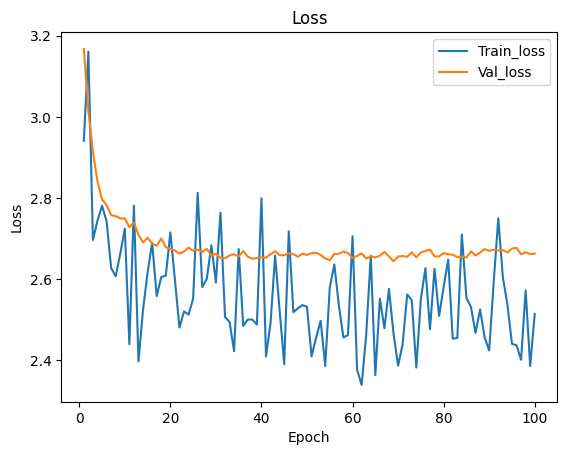

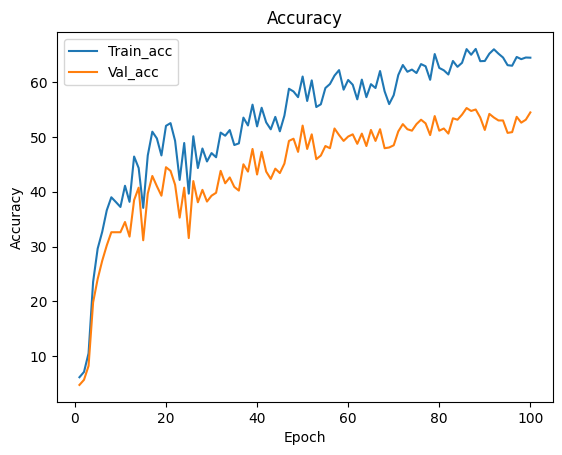

In [ ]:
n_inputs = 100*20 # makes a 1D vector of 2000
n_outputs = 26
model = LogisticRegression(n_inputs, n_outputs).to(device)
# checkpoint = torch.load(os.path.join(save_model_path,"log_regr.pth"))
print(model)
train1(model)

In [ ]:
model = LogisticRegression(n_inputs, n_outputs).to(device)
checkpoint = torch.load(os.path.join(save_model_path,"log_regr.pth"))
model.load_state_dict(checkpoint['model_state_dict'])
val1(model)

(2.6632171488822776, 48.73501997336884)